In [1]:
samples = []

with open('Data/oznaczenia.txt') as fp:
    for line in fp.readlines():
        [filename, end, start] = line[:-1].split("\t")
        samples.append((filename, int(start), int(end)))

samples

[('0001_1_.nii.gz', 105, 137),
 ('0001_2_.nii.gz', 100, 132),
 ('0002_1_.nii.gz', 93, 130),
 ('0002_2_.nii.gz', 87, 123),
 ('0003_1_.nii.gz', 100, 131),
 ('0003_2_.nii.gz', 101, 133),
 ('0004_1_.nii.gz', 169, 200),
 ('0004_2_.nii.gz', 162, 191),
 ('0005_1_.nii.gz', 120, 151),
 ('0006_1_.nii.gz', 183, 214),
 ('0006_2_.nii.gz', 179, 212),
 ('0007_1_.nii.gz', 189, 222),
 ('0007_2_.nii.gz', 108, 145),
 ('0008_1_.nii.gz', 186, 216),
 ('0008_2_.nii.gz', 169, 199),
 ('0009_1_.nii.gz', 183, 219),
 ('0009_2_.nii.gz', 173, 212),
 ('0010_1_.nii.gz', 168, 197),
 ('0010_2_.nii.gz', 104, 134)]

In [2]:
import torch
import nibabel as nib
import random

slices = []
targets = []

for filename, start, end in samples:
    img = nib.load(f"Data/{filename}").get_fdata()
    # Positive slices
    for depth in range(start, end + 1):
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(1)
    negative_indices = list(range(0, start)) + list(range(end, img.shape[2]))
    chosen_negative_indices = random.sample(negative_indices, end - start + 1)
    for depth in chosen_negative_indices:
        s = img[:, :, depth]
        slices.append(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        targets.append(0)
    

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(slices, targets, test_size=0.2)
print(len(X_train))
print(f"{sum(y_train)}/{len(y_train)}")
print(f"{sum(y_test)}/{len(y_test)}")
print(len(X_test))

1020
515/1020
123/256
256


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class SlicesDataset:
    def __init__(self, slices: torch.tensor, targets: List[bool], transform = None):
        self.slices = slices
        self.targets = torch.tensor(targets, dtype=torch.int64)
        self.transform = transform

    def __getitem__(self, idx):
        s = self.transform(self.slices[idx]) if self.transform is not None else self.slices[idx]
        target = F.one_hot(self.targets[idx], 2).float()
        return s, target
        
    def __len__(self):
        return len(self.targets)


transform = transforms.Compose([
    # bigger
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.RandomErasing(scale=(0.02, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine((-15, 15), (0.01, 0.1), (0.9, 1.05)),
    transforms.RandomPerspective(0.2)
])

train_dataset = SlicesDataset(X_train, y_train, transform)
test_dataset = SlicesDataset(X_test, y_test, transform)

# TODO: sampler
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

tensor([1., 0.])


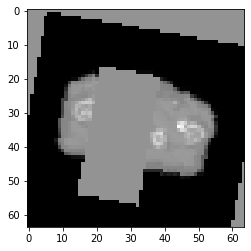

In [5]:
import matplotlib.pyplot as plt

s, target = next(iter(train_loader))

print(target[0])
plt.gray()
plt.imshow(s[0][0])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Initialize a Convolutional Neural Network with Batch Normalization.
        
        Args:
            num_classes (int): Number of output classes (default: 10 for CIFAR-10)
        """
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(inplace=True)
        # )
        
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(inplace=True)
        # )
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(32768, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.20)
        )
        
        self.fc2 = nn.Linear(256, num_classes)

    
    def forward(self, x):
        # First convolutional block
        x = self.pool(self.conv1(x))
        
        #Second convolutional block
        # x = self.pool(self.conv2(x))
        
        # Third convolutional block
        # x = self.pool(self.conv3(x))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with batch norm and dropout
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

model = SimpleCNN(2).to(device)
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [8]:
from tqdm import tqdm

def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training Epoch"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, true_predictions = torch.max(labels, 1)
        correct += (predicted == true_predictions).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy

# Testing loop
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation during testing
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track the loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, true_predictions = torch.max(labels, 1)
            correct += (predicted == true_predictions).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct / total * 100
    return epoch_loss, epoch_accuracy


def train_loop(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
        # Testing
        test_loss, test_accuracy = test(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    return {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_acc": train_accuracies,
        "test_acc": test_accuracies
    }

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

history = train_loop(model, train_loader, test_loader, criterion, optimizer, device, 30)

Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.19it/s]


Epoch 1/30 - Train Loss: 8.1487, Train Accuracy: 54.41%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch 1/30 - Test Loss: 3.0550, Test Accuracy: 54.69%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Epoch 2/30 - Train Loss: 2.5607, Train Accuracy: 62.35%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]


Epoch 2/30 - Test Loss: 0.9202, Test Accuracy: 69.92%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch 3/30 - Train Loss: 1.6899, Train Accuracy: 63.33%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch 3/30 - Test Loss: 1.0397, Test Accuracy: 74.22%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.70it/s]


Epoch 4/30 - Train Loss: 1.1180, Train Accuracy: 68.63%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Epoch 4/30 - Test Loss: 1.3003, Test Accuracy: 69.14%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch 5/30 - Train Loss: 0.6784, Train Accuracy: 73.14%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 5/30 - Test Loss: 0.5599, Test Accuracy: 78.12%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


Epoch 6/30 - Train Loss: 0.5105, Train Accuracy: 75.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


Epoch 6/30 - Test Loss: 0.4930, Test Accuracy: 75.78%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch 7/30 - Train Loss: 0.4921, Train Accuracy: 75.59%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


Epoch 7/30 - Test Loss: 0.4618, Test Accuracy: 78.12%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch 8/30 - Train Loss: 0.4671, Train Accuracy: 77.16%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch 8/30 - Test Loss: 0.4882, Test Accuracy: 72.27%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch 9/30 - Train Loss: 0.4693, Train Accuracy: 76.57%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]


Epoch 9/30 - Test Loss: 0.4897, Test Accuracy: 74.22%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]


Epoch 10/30 - Train Loss: 0.4557, Train Accuracy: 78.82%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


Epoch 10/30 - Test Loss: 0.4357, Test Accuracy: 81.64%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


Epoch 11/30 - Train Loss: 0.4182, Train Accuracy: 80.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]


Epoch 11/30 - Test Loss: 0.4182, Test Accuracy: 78.91%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch 12/30 - Train Loss: 0.4247, Train Accuracy: 80.00%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


Epoch 12/30 - Test Loss: 0.4103, Test Accuracy: 82.81%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


Epoch 13/30 - Train Loss: 0.3921, Train Accuracy: 82.65%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]


Epoch 13/30 - Test Loss: 0.4155, Test Accuracy: 82.42%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.72it/s]


Epoch 14/30 - Train Loss: 0.3998, Train Accuracy: 82.45%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch 14/30 - Test Loss: 0.4290, Test Accuracy: 78.52%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


Epoch 15/30 - Train Loss: 0.4075, Train Accuracy: 80.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch 15/30 - Test Loss: 0.4056, Test Accuracy: 82.81%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


Epoch 16/30 - Train Loss: 0.3904, Train Accuracy: 81.18%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 16/30 - Test Loss: 0.4045, Test Accuracy: 83.20%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch 17/30 - Train Loss: 0.4054, Train Accuracy: 81.57%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch 17/30 - Test Loss: 0.4118, Test Accuracy: 80.86%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.83it/s]


Epoch 18/30 - Train Loss: 0.3745, Train Accuracy: 83.92%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 18/30 - Test Loss: 0.3927, Test Accuracy: 83.98%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch 19/30 - Train Loss: 0.3716, Train Accuracy: 83.14%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 19/30 - Test Loss: 0.4062, Test Accuracy: 81.25%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch 20/30 - Train Loss: 0.4024, Train Accuracy: 80.88%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]


Epoch 20/30 - Test Loss: 0.3486, Test Accuracy: 86.33%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.81it/s]


Epoch 21/30 - Train Loss: 0.3755, Train Accuracy: 84.02%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch 21/30 - Test Loss: 0.3478, Test Accuracy: 85.94%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.76it/s]


Epoch 22/30 - Train Loss: 0.3934, Train Accuracy: 82.65%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch 22/30 - Test Loss: 0.3839, Test Accuracy: 85.94%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


Epoch 23/30 - Train Loss: 0.3636, Train Accuracy: 84.61%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]


Epoch 23/30 - Test Loss: 0.3770, Test Accuracy: 82.03%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]


Epoch 24/30 - Train Loss: 0.3573, Train Accuracy: 83.82%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


Epoch 24/30 - Test Loss: 0.3452, Test Accuracy: 85.16%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch 25/30 - Train Loss: 0.3687, Train Accuracy: 85.00%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


Epoch 25/30 - Test Loss: 0.3475, Test Accuracy: 85.55%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


Epoch 26/30 - Train Loss: 0.3393, Train Accuracy: 84.80%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 26/30 - Test Loss: 0.3637, Test Accuracy: 84.38%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch 27/30 - Train Loss: 0.3666, Train Accuracy: 85.10%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch 27/30 - Test Loss: 0.3620, Test Accuracy: 84.38%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Epoch 28/30 - Train Loss: 0.3591, Train Accuracy: 84.80%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 28/30 - Test Loss: 0.3337, Test Accuracy: 87.11%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch 29/30 - Train Loss: 0.3294, Train Accuracy: 86.67%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch 29/30 - Test Loss: 0.3026, Test Accuracy: 87.11%


Training Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


Epoch 30/30 - Train Loss: 0.3284, Train Accuracy: 86.08%


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]

Epoch 30/30 - Test Loss: 0.3415, Test Accuracy: 85.16%


In [9]:
history["test_acc"][-10:]

[85.9375,
 85.9375,
 82.03125,
 85.15625,
 85.546875,
 84.375,
 84.375,
 87.109375,
 87.109375,
 85.15625]

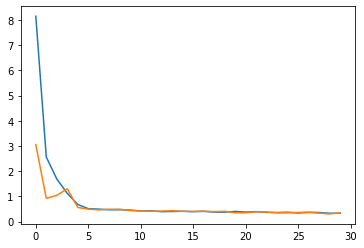

In [10]:
import matplotlib.pyplot as plt

epochs = list(range(len(history["test_acc"])))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["test_loss"], label="Test loss")

In [11]:
def make_classification(model, ct, device, transform):
    result = []
    for depth in range(ct.shape[2]):
        s = transform(torch.tensor(ct[:, :, depth], dtype=torch.float, device=device).unsqueeze(0))
        c = torch.argmax(model(s.unsqueeze(0))).item()
        result.append(c)
    return result

In [12]:
def find_voi(classification, n_neigh=3):
    # TODO: change algorithm
    result = []
    for i in range(len(classification)):
        left = classification[max(0, i - n_neigh):i + 1]
        right = classification[i:min(len(classification), i + n_neigh)]
        decision = int((all(left) and len(left) != 1) or (all(right) and len(right) != 1))
        result.append(decision)
    start = result.index(1) if 1 in result else 0
    end = start + sum(result)
    return start, end

In [14]:
import pandas as pd

n_neigh = 10

data = {
    "sample": list(),
    "start": list(),
    "end": list(),
    "predicted_start": list(),
    "predicted_end": list(),
    "metric": list()
}

for sample, start, end in samples:
    ct = nib.load(f"Data/{sample}").get_fdata()
    classification = make_classification(model, ct, device)
    predicted_start, predicted_end = find_voi(classification, n_neigh)
    metric = abs(predicted_start - start) + abs(predicted_end - end)
    data["sample"].append(sample)
    data["start"].append(start)
    data["end"].append(end)
    data["predicted_start"].append(predicted_start)
    data["predicted_end"].append(predicted_end)
    data["metric"].append(metric)

df = pd.DataFrame(data)
df

,sample,start,end,predicted_start,predicted_end,metric
0,0001_1_.nii.gz,105,137,139,142,39
1,0001_2_.nii.gz,100,132,1,2,229
2,0002_1_.nii.gz,93,130,73,107,43
3,0002_2_.nii.gz,87,123,74,130,20
4,0003_1_.nii.gz,100,131,75,132,26
5,0003_2_.nii.gz,101,133,79,127,28
6,0004_1_.nii.gz,169,200,158,233,44
7,0004_2_.nii.gz,162,191,152,157,44
8,0005_1_.nii.gz,120,151,119,174,24
9,0006_1_.nii.gz,183,214,164,237,42


In [15]:
df["metric"].mean()

51.0

In [16]:
df

,sample,start,end,predicted_start,predicted_end,metric
0,0001_1_.nii.gz,105,137,139,142,39
1,0001_2_.nii.gz,100,132,1,2,229
2,0002_1_.nii.gz,93,130,73,107,43
3,0002_2_.nii.gz,87,123,74,130,20
4,0003_1_.nii.gz,100,131,75,132,26
5,0003_2_.nii.gz,101,133,79,127,28
6,0004_1_.nii.gz,169,200,158,233,44
7,0004_2_.nii.gz,162,191,152,157,44
8,0005_1_.nii.gz,120,151,119,174,24
9,0006_1_.nii.gz,183,214,164,237,42


In [13]:
samples = []

with open('testData/ranges.txt') as fp:
    for idx, line in enumerate(fp.readlines()):
        [start, end] = line[:-1].split(" ")
        filename = f"{idx}.nii.gz"
        samples.append((filename, int(start), int(end)))

samples

[('0.nii.gz', 25, 47),
 ('1.nii.gz', 24, 46),
 ('2.nii.gz', 22, 46),
 ('3.nii.gz', 43, 86),
 ('4.nii.gz', 19, 38),
 ('5.nii.gz', 30, 49),
 ('6.nii.gz', 21, 43),
 ('7.nii.gz', 26, 46),
 ('8.nii.gz', 66, 87),
 ('9.nii.gz', 21, 44)]

In [22]:
import pandas as pd

n_neigh = 15

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

data = {
    "sample": list(),
    "start": list(),
    "end": list(),
    "predicted_start": list(),
    "predicted_end": list(),
    "metric": list()
}

for sample, start, end in samples:
    ct = nib.load(f"testData/{sample}").get_fdata()
    classification = make_classification(model, ct, device, transform)
    predicted_start, predicted_end = find_voi(classification, n_neigh)
    metric = abs(predicted_start - start) + abs(predicted_end - end)
    data["sample"].append(sample)
    data["start"].append(start)
    data["end"].append(end)
    data["predicted_start"].append(predicted_start)
    data["predicted_end"].append(predicted_end)
    data["metric"].append(metric)

df = pd.DataFrame(data)
df

,sample,start,end,predicted_start,predicted_end,metric
0,0.nii.gz,25,47,24,45,3
1,1.nii.gz,24,46,22,23,25
2,2.nii.gz,22,46,20,39,9
3,3.nii.gz,43,86,42,88,3
4,4.nii.gz,19,38,14,45,12
5,5.nii.gz,30,49,16,50,15
6,6.nii.gz,21,43,15,46,9
7,7.nii.gz,26,46,14,53,19
8,8.nii.gz,66,87,56,94,17
9,9.nii.gz,21,44,16,35,14


In [23]:
df["metric"].mean()

12.6

In [16]:
torch.save(model.state_dict(), 'model.pth')